Visualising high dimensional spaces using Bayesian GPLVM
--
*Alexis Boukouvalas, June 2016*

 - Sample from a periodic kernel
 - Visualise the space using Baysian GPLVM

In [1]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12,6)
matplotlib.style.use('ggplot')
%matplotlib inline
import GPflow
import numpy as np
import tensorflow as tf

In [68]:
Q = 2 # latent dimension
D = 5 # true dimension
N = 100
lengthscale = 11.5
variance = 1.3
rng = np.random.RandomState(1)
X_data1 = rng.multivariate_normal(np.zeros(D), 0.1*np.eye(D), N)
X_data2 = rng.multivariate_normal(2*np.ones(D), 1*np.eye(D), N)
X_data  = np.vstack([X_data1,X_data2])
idx = np.vstack([np.ones((N,1)), 2*np.ones((N,1))])
kernel = GPflow.kernels.RBF(Q, variance=variance, lengthscales=lengthscale)

In [69]:
x_free = tf.placeholder('float64')
kernel.make_tf_array(x_free)
X = tf.placeholder('float64')

with kernel.tf_mode():
    K = tf.Session().run(kernel.K(X),
                                   feed_dict={x_free: kernel.get_free_state(), X: X_data})
tol = 10e-6
L = np.linalg.cholesky(K + np.eye(K.shape[0])*tol)
Y=L.dot(np.random.randn(L.shape[0],D))

In [70]:
Y.shape

(200, 5)

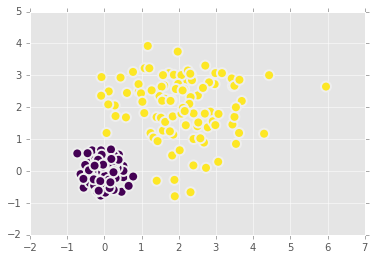

In [71]:
plt.scatter(X_data[:,0], X_data[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

(200, 2)


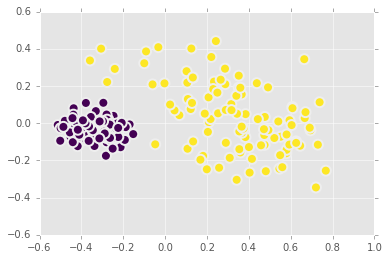

In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=Q)
Xinit = pca.fit_transform(Y)
print Xinit.shape
plt.scatter(Xinit[:,0], Xinit[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

(10, 2)
compiling tensorflow function...
done


InvalidArgumentError: LLT decomposition was not successful. The input might not be valid.
	 [[Node: Cholesky_27 = Cholesky[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/cpu:0"](add_454)]]
Caused by op u'Cholesky_27', defined at:
  File "/home/mqbssaby/anaconda2/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mqbssaby/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2831, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-104-32313d707777>", line 27, in <module>
    m.optimize(max_iters = 33)
  File "/home/mqbssaby/python/GPflow/GPflow/model.py", line 262, in optimize
    return self._optimize_np(method, tol, callback, max_iters, **kw)
  File "/home/mqbssaby/python/GPflow/GPflow/model.py", line 325, in _optimize_np
    self._compile()
  File "/home/mqbssaby/python/GPflow/GPflow/model.py", line 169, in _compile
    f = self.build_likelihood() + self.build_prior()
  File "/home/mqbssaby/python/GPflow/GPflow/gplvm.py", line 56, in build_likelihood
    with tf.name_scope('gplvm_A'):
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 240, in cholesky
    return _op_def_lib.apply_op("Cholesky", input=input, name=name)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 683, in apply_op
    op_def=op_def)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2154, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/mqbssaby/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1154, in __init__
    self._traceback = _extract_stack()


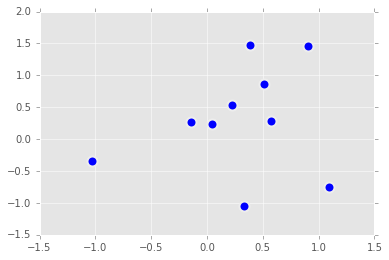

In [104]:
# Bayesian GPLVM model
from GPflow import gplvm

# Create 49 inducings points on a grid
fGrid = False
if(fGrid):
    Z1, Z2 = np.mgrid[X_data.min():X_data.max():7j, X_data.min():X_data.max():7j]
    Z = np.vstack([Z1.ravel(), Z2.ravel()]).T
else:
    Z = rng.multivariate_normal(np.zeros(Q), np.eye(Q), 10)

plt.scatter(Z[:,0], Z[:,1], 100, lw=2, cmap=plt.cm.viridis)

print Z.shape

# just optimize X
kernel.variance.fixed = True
kernel.lengthscales.fixed = True

# m = GPflow.gplvm.BayesianGPLVM(X_mean = np.zeros((2*N,Q)), 
#             X_var=np.ones((2*N,Q)), Y=Y, kern=kernel, Z=Z)

m = GPflow.gplvm.BayesianGPLVM(X_mean = Xinit,
                X_var=2*np.ones((2*N,Q)), Y=Y, kern=kernel, Z=Z)


m.optimize(max_iters = 33)

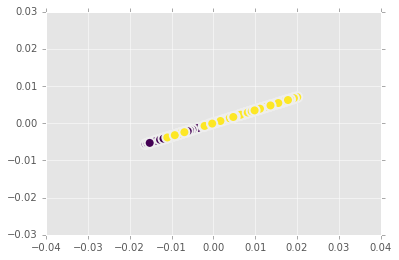

In [87]:
Xinf = m.X_mean._array
plt.scatter(Xinf[:,0], Xinf[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)

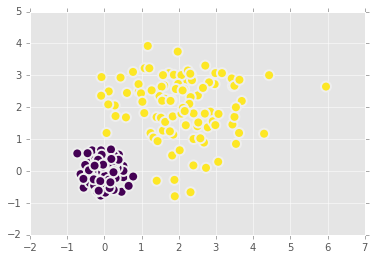

In [88]:
plt.scatter(X_data[:,0], X_data[:,1], 100, idx, lw=2, cmap=plt.cm.viridis)